# 2강. 없다면 어떻게 될까? (ResNet Ablation Study)
## 2-3. Ablation Study 실습 (1) CIFAR-10 데이터셋 준비하기
### 1) CIFAR-10
- [cifar-10 자료](https://www.tensorflow.org/datasets/catalog/cifar10)

In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [2]:
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
import urllib3
urllib3.disable_warnings()

#tfds.disable_progress_bar() # 데이터셋 다운로드 과정의 프로그레스 바 숨기기

(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling cifar10-train.tfrecord...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling cifar10-test.tfrecord...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset cifar10 downloaded and prepared to /aiffel/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


In [4]:
# feature 정보를 확인(Tensorflow 데이터셋 로드 시 필수)
print(ds_info.features)

FeaturesDict({
    'id': Text(shape=(), dtype=tf.string),
    'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
})


In [5]:
# 데이터의 개수 확인
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(50000, shape=(), dtype=int64)
tf.Tensor(10000, shape=(), dtype=int64)


- Tensorflow 데이터셋은 Numpy가 아니기 때문에 ds_train.shape 사용 불가

### 2) Input Normalization
- Data Normalization : 데이터의 범위를 사용자가 원하는 범위로 제한하는 것. 이미지 데이터의 경우 픽셀 정보를 0~255사이의 값으로 가지므로 255로 나누어주어 0~1.0사이의 값을 가지도록 만드는 것이다. (정규화하고자 하는 값 - 데이터 값들 중 최소값) / (데이터 값들 중 최대값 - 데이터 값들 중 최소값)  
- Data Normalization을 하는 이유 : 머신러닝에서 scale이 큰 feature의 영향이 비대해지는 것을 방지하고, 딥러닝에서 Local optimum에 빠질 위험을 줄이며 학습 속도를 향상시킬 수 있기 때문이다.

In [6]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    # image = tf.image.resize(image, [32, 32])
    return tf.cast(image, tf.float32) / 255., label

In [7]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [8]:
# cifar-10 클래스 개수
ds_info.features["label"].num_classes

10

In [9]:
# cifar-10 클래스 이름
ds_info.features["label"].names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

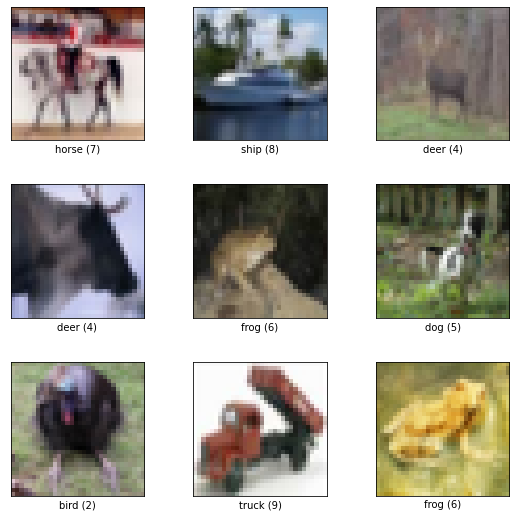

In [10]:
# train set 예시
fig = tfds.show_examples(ds_train, ds_info)

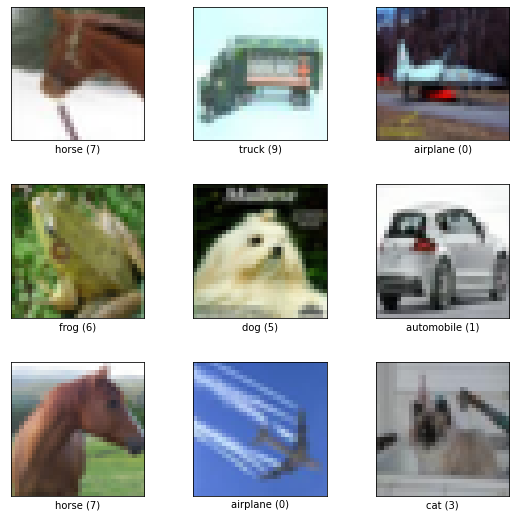

In [11]:
# test set 예시
fig = tfds.show_examples(ds_test, ds_info)

## 2-4. Ablation Study 실습 (2) 블록 구성하기
### VGG 기본 블록 만들기

In [12]:
# function for building VGG Block

def build_vgg_block(input_layer,
                    num_cnn=3, 
                    channel=64,
                    block_num=1,
                   ):
    # 입력 레이어
    x = input_layer

    # CNN 레이어
    for cnn_num in range(num_cnn):
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(3,3),
            activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_conv{cnn_num}'
        )(x)    

    # Max Pooling 레이어
    x = keras.layers.MaxPooling2D(
        pool_size=(2, 2),
        strides=2,
        name=f'block{block_num}_pooling'
    )(x)

    return x

In [13]:
vgg_input_layer = keras.layers.Input(shape=(32,32,3))   # 입력 레이어 생성
vgg_block_output = build_vgg_block(vgg_input_layer)    # VGG 블록 생성

- [tf.keras.Model](https://www.tensorflow.org/api_docs/python/tf/keras/Model)

In [14]:
# 블록 1개짜리 model 생성
model = keras.Model(inputs=vgg_input_layer, outputs=vgg_block_output)  

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv0 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pooling (MaxPooling2D (None, 16, 16, 64)        0         
Total params: 75,648
Trainable params: 75,648
Non-trainable params: 0
_________________________________________________________________


## 2-5. Ablation Study 실습 (3) VGG Complete Model

![VGG-16, VGG-19 구조](https://user-images.githubusercontent.com/116326867/211470306-95e3e2c9-6556-4b3b-9252-c09bc9c61b9a.png)

### 1) VGG-16

In [15]:
# VGG 모델 자체를 생성하는 함수
def build_vgg(input_shape=(32,32,3),
              num_cnn_list=[2,2,3,3,3], # 블록 내 CNN 레이어 수는 블록마다 달라짐
              channel_list=[64,128,256,512,512], # 블록 내 CNN 채널 수도 블록마다 달라짐
              num_classes=10):
    
    assert len(num_cnn_list) == len(channel_list) #모델을 만들기 전에 config list들이 같은 길이인지 확인
    
    input_layer = keras.layers.Input(shape=input_shape)  # input layer 만들기
    output = input_layer
    
    # config list들의 길이만큼 반복해서 블록 생성
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output = build_vgg_block(
            output,
            num_cnn=num_cnn, 
            channel=channel,
            block_num=i
        )
        
    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(4096, activation='relu', name='fc1')(output)
    output = keras.layers.Dense(4096, activation='relu', name='fc2')(output)
    output = keras.layers.Dense(num_classes, activation='softmax', name='predictions')(output)
    
    model = keras.Model(
        inputs=input_layer, 
        outputs=output
    )
    return model

In [16]:
# 기본값을 그대로 사용해서 VGG 모델을 만들면 VGG-16
vgg_16 = build_vgg()

vgg_16.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block0_conv0 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block0_conv1 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block0_pooling (MaxPooling2D (None, 16, 16, 64)        0         
_________________________________________________________________
block1_conv0 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block1_pooling (MaxPooling2D (None, 8, 8, 128)         0   

### 2) VGG-19

In [17]:
# 원하는 블록의 설계에 따라 매개변수로 리스트를 전달
vgg_19 = build_vgg(
    num_cnn_list=[2,2,4,4,4],
    channel_list=[64,128,256,512,512]
)

vgg_19.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block0_conv0 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block0_conv1 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block0_pooling (MaxPooling2D (None, 16, 16, 64)        0         
_________________________________________________________________
block1_conv0 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block1_pooling (MaxPooling2D (None, 8, 8, 128)         0   

## 2-6. Ablation Study 실습 (4) VGG-16 vs VGG-19 (모델 성능 비교)

In [18]:
BATCH_SIZE = 256
EPOCH = 15

In [19]:
# CIFAR-10 데이터셋 불러오기
(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

<span style="color:red">!주의!</span> BATCH_SIZE가 커지면 소요시간이 다소 줄어들기는 하지만 학습하는데 시간이 오래 걸릴 수 있다. 40Epoch정도 수행하는 것을 권장.(시간 상 15Epoch로도 어느 정도 근접하는 성능 얻을 수 있음)

In [20]:
# vgg_16 모델 훈련하기
vgg_16.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_16 = vgg_16.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/15
195/195 [==============================] - 65s 135ms/step - loss: 2.1882 - accuracy: 0.1873 - val_loss: 2.0684 - val_accuracy: 0.2384
Epoch 2/15
195/195 [==============================] - 24s 121ms/step - loss: 1.9932 - accuracy: 0.2760 - val_loss: 1.9196 - val_accuracy: 0.3069
Epoch 3/15
195/195 [==============================] - 24s 122ms/step - loss: 1.8726 - accuracy: 0.3284 - val_loss: 1.7991 - val_accuracy: 0.3744
Epoch 4/15
195/195 [==============================] - 24s 123ms/step - loss: 1.7612 - accuracy: 0.3688 - val_loss: 1.7071 - val_accuracy: 0.3852
Epoch 5/15
195/195 [==============================] - 24s 125ms/step - loss: 1.6794 - accuracy: 0.3954 - val_loss: 1.6276 - val_accuracy: 0.4120
Epoch 6/15
195/195 [==============================] - 25s 126ms/step - loss: 1.6153 - accuracy: 0.4163 - val_loss: 1.5476 - val_accuracy: 0.4451
Epoch 7/15
195/195 [==============================] - 24s 125ms/step - loss: 1.5532 - accuracy: 0.4425 - val_loss: 1.5493 - val_ac

<span style="color:red">!주의!</span> 파라미터가 더 많은 VGG-19는 VGG-16보다 1/4 정도 훈련 시간이 더 걸린다. Epoch 수나 BATCH_SIZE를 잘 조절해 줄 것.

In [21]:
# vgg_19 모델 훈련하기
vgg_19.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_19 = vgg_19.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
195/195 [==============================] - 34s 148ms/step - loss: 2.2286 - accuracy: 0.1666 - val_loss: 2.1216 - val_accuracy: 0.2560
Epoch 2/15
195/195 [==============================] - 29s 149ms/step - loss: 2.0413 - accuracy: 0.2494 - val_loss: 1.9575 - val_accuracy: 0.2879
Epoch 3/15
195/195 [==============================] - 28s 146ms/step - loss: 1.9002 - accuracy: 0.3052 - val_loss: 1.8106 - val_accuracy: 0.3427
Epoch 4/15
195/195 [==============================] - 29s 148ms/step - loss: 1.7817 - accuracy: 0.3520 - val_loss: 1.7405 - val_accuracy: 0.3765
Epoch 5/15
195/195 [==============================] - 29s 147ms/step - loss: 1.6841 - accuracy: 0.3934 - val_loss: 1.6764 - val_accuracy: 0.3999
Epoch 6/15
195/195 [==============================] - 29s 148ms/step - loss: 1.6211 - accuracy: 0.4113 - val_loss: 1.5430 - val_accuracy: 0.4482
Epoch 7/15
195/195 [==============================] - 29s 148ms/step - loss: 1.5618 - accuracy: 0.4380 - val_loss: 1.5663 - val_ac

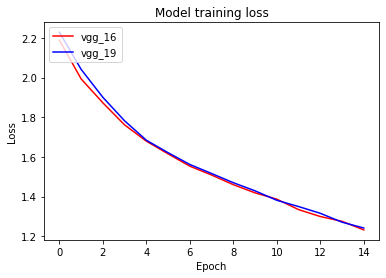

In [22]:
# 훈련 손실(training loss) 비교 시각화
import matplotlib.pyplot as plt

plt.plot(history_16.history['loss'], 'r')
plt.plot(history_19.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['vgg_16', 'vgg_19'], loc='upper left')
plt.show()

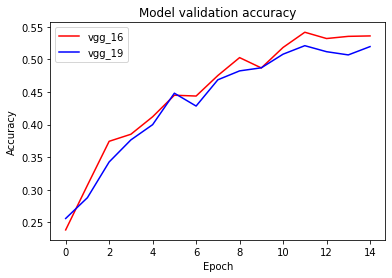

In [23]:
# 검증 정확도(validation accuracy) 비교 시각화
plt.plot(history_16.history['val_accuracy'], 'r')
plt.plot(history_19.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['vgg_16', 'vgg_19'], loc='upper left')
plt.show()